<h1>Forecasting Week 8: Fourier, Kalman, and Facebook Prophet</h1>
<br>
1 Frequency Analysis (Fourier Analysis) for Time Series Data<br>
2 Implementation of Kalman Filter<br>
3 Additive Regression Model with Facebook Prophet<br>
4 Example: Predict electricity consumption<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
from scipy.fft import ifft
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error

<h1>1 Frequency Analysis (Fourier Analysis) for Time Series Data</h1>

In [2]:
# Set frequencies, amplitudes, sampling rate and time range:
f1 =  2  # Frequency 1 in Hz
f2 = 10  # Frequency 2 in Hz
A1 = 6   # Amplitude 1
A2 = 2   # Amplitude 2
Fs = 100 # Sampling rate
t  = np.arange(0,1,1/Fs)

# Calculate prime number signals:
A_sin = A1 * np.sin(2 * np.pi * f1 * t)
A_cos = A2 * np.cos(2 * np.pi * f2 * t)
A_signal = A_sin + A_cos

# add some noise:
np.random.seed(1)
A_Noise = 2
Noise = np.random.randn(len(t)) * A_Noise
A_signal_noisy = A_signal + Noise

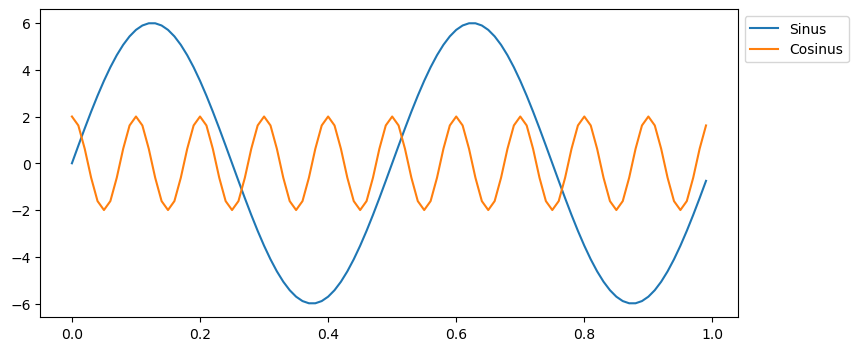

In [3]:
fig=plt.figure(3, figsize=(9,4))
plt.plot(t, A_sin, label="Sinus")
plt.plot(t, A_cos, label="Cosinus")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

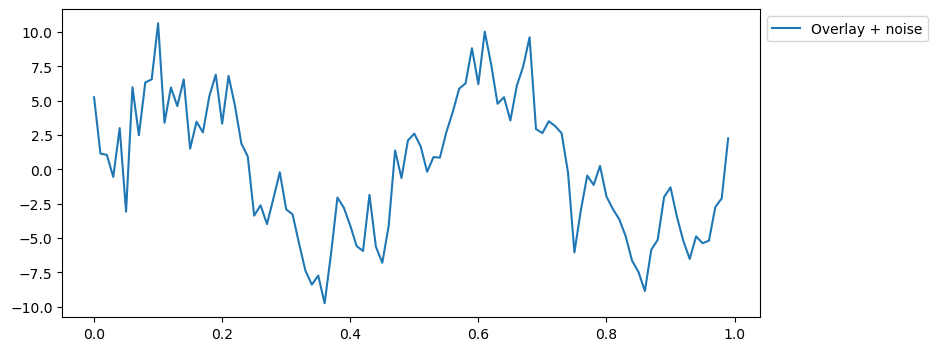

In [4]:
fig=plt.figure(3, figsize=(9,4))
#plt.plot(t, A_signal, label="Overlay")
plt.plot(t, A_signal_noisy, label="Overlay + noise")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

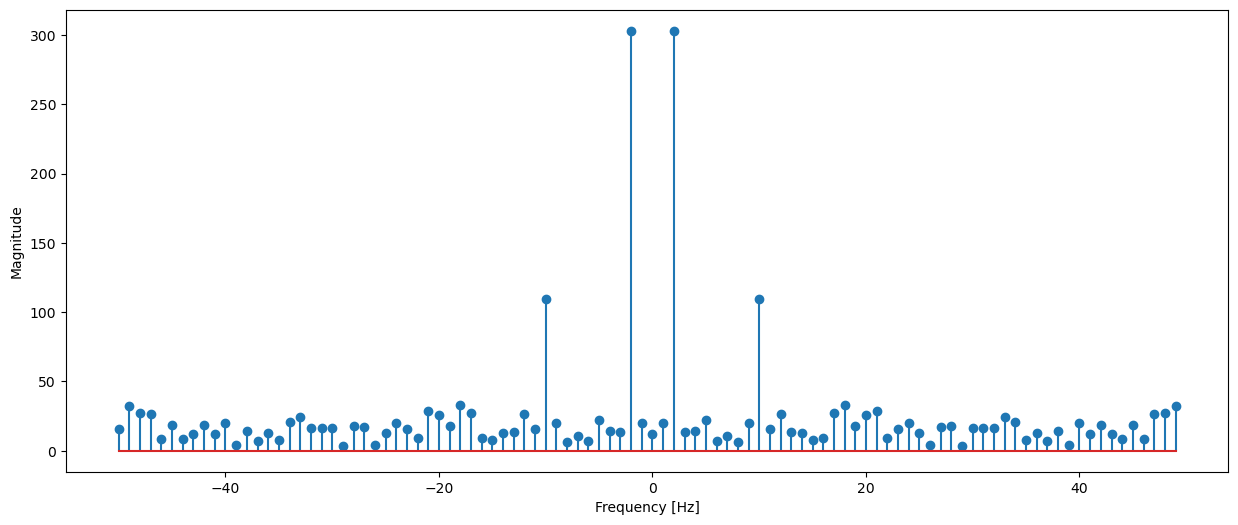

In [5]:
A_signal_fft = scipy.fft.fft(A_signal_noisy)
freq = scipy.fft.fftfreq(np.size(t), 1/Fs)

fig=plt.figure(2, figsize=(15,6))
plt.stem(freq, np.abs(A_signal_fft))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude");

In [6]:
threshold = 50  # Replace with your desired threshold
filter_mask = np.abs(A_signal_fft) > threshold

filtered_fft = A_signal_fft * filter_mask

filtered_signal = scipy.fft.ifft(filtered_fft)

filtered_signal_real = np.real(filtered_signal)

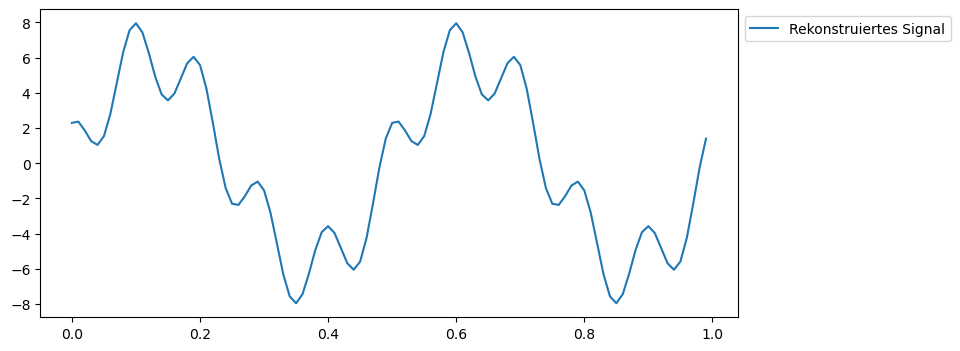

In [7]:
fig=plt.figure(3, figsize=(9,4))
plt.plot(t, filtered_signal_real, label="Rekonstruiertes Signal")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

<div class="alert alert-info">
- Generate a different signal (by changing the frequencies, amplitudes, sampling rate)<br>
- How does your plot of the overlay change with the respective changes above?<br>
- Perform an FFT and plot the result as above<br>
- How does your FFT plot change with the respective changes above (frequencies, amplitudes, sampling rate)?
</div>

<h1>2) Implementation of Kalman Filter</h1>

In [8]:
# Simulated data: True state (position) of a moving object
np.random.seed(0)
n = 100  # Number of time steps
true_position = np.cumsum(np.random.normal(0, 1, n))

# Simulated data: Measurements with noise
measurement_noise = 0.5
measurements = true_position + np.random.normal(0, measurement_noise, n)

# Initialization of the Kalman filter
initial_state = 0  # Initial estimate of the position
initial_estimate_error = 1  # Initial estimate of error variance

# Kalman filter parameters
process_noise = 0.1  # Model for uncertainty in state transition
measurement_noise = 0.5  # Uncertainty in the measurements

# Lists to store the estimates and error variances
estimated_states = []
estimate_errors = []

# Initialization
current_state = initial_state
current_estimate_error = initial_estimate_error

In [9]:
# Kalman filter loop
for measurement in measurements:
    # Prediction
    predicted_state = current_state
    predicted_estimate_error = current_estimate_error + process_noise

    # Correction
    kalman_gain = predicted_estimate_error / (predicted_estimate_error + measurement_noise)
    current_state = predicted_state + kalman_gain * (measurement - predicted_state)
    current_estimate_error = (1 - kalman_gain) * predicted_estimate_error

    # Save estimates
    estimated_states.append(current_state)
    estimate_errors.append(current_estimate_error)

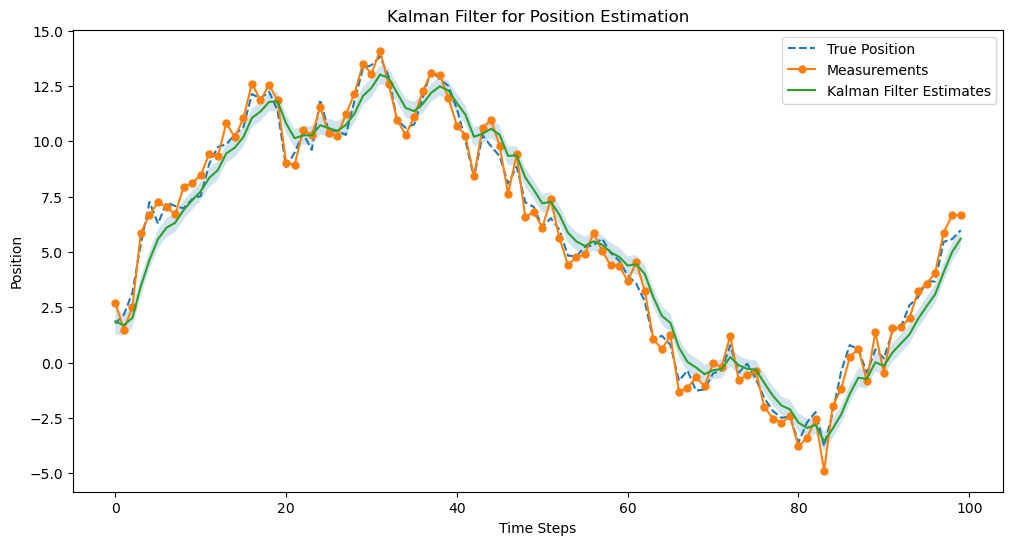

In [10]:
# Plotting the true position, measurements, and Kalman filter estimates
plt.figure(figsize=(12, 6))
plt.plot(true_position, label='True Position', linestyle='--')
plt.plot(measurements, label='Measurements', marker='o', markersize=5)
plt.plot(estimated_states, label='Kalman Filter Estimates')
plt.fill_between(range(n), np.array(estimated_states) - np.sqrt(estimate_errors),
                 np.array(estimated_states) + np.sqrt(estimate_errors), alpha=0.2)
plt.title('Kalman Filter for Position Estimation')
plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.legend()
plt.show()


<h1>3) Predictions with Facebook Prophet</h1>

<h3>Airline Data</h3>

In [11]:
#!conda install -c conda-forge prophet

In [12]:
airline = pd.read_csv('AirPassengers.csv')
airline.columns = ['ds','y']
airline['ds'] = pd.to_datetime(airline['ds'])
airline['ds'].freq = 'MS'
airline.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [13]:
airline.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


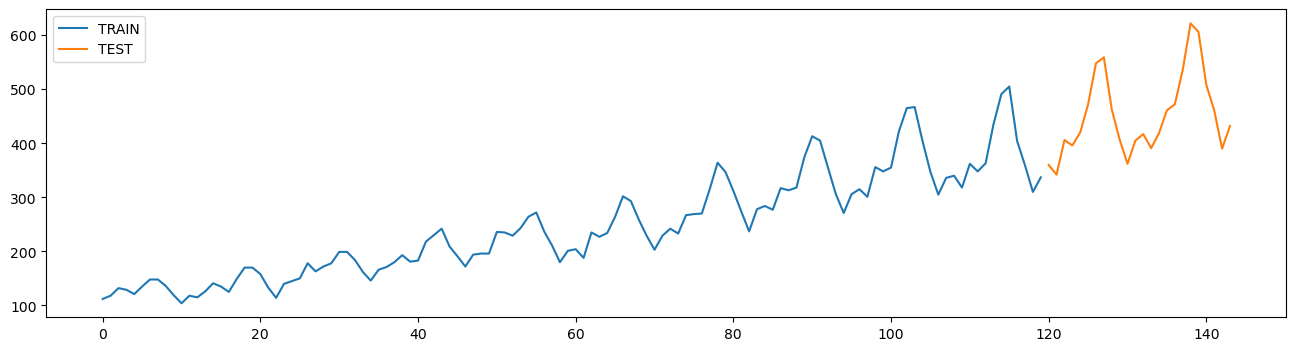

In [14]:
train_airline = airline[:120]
test_airline = airline[120:]
train_airline['y'].plot(legend=True,label='TRAIN')
test_airline['y'].plot(legend=True,label='TEST',figsize=(16,4));

In [15]:
model_air = Prophet()

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [ ]:
model_air.fit(train_airline)

In [ ]:
future_air = model_air.make_future_dataframe(periods=24, freq = 'MS')

In [ ]:
forecast_prophet = model_air.predict(future_air)
forecast_prophet.tail()

In [ ]:
model_air.plot(forecast_prophet);

In [ ]:
fig = plt.figure(figsize = (14,4))
ax = fig.add_subplot(111)

ax.plot(train_airline['ds'], train_airline['y'], label = 'TRAIN')
ax.plot(test_airline['ds'], test_airline['y'], label = 'TEST')
ax.plot(pred_air['ds'], forecast_prophet['yhat'], label = 'PROPHET')
plt.legend(loc='upper left');
plt.show()

<div class="alert alert-info">
1. Airline-Daten <br>
- Wie performt das Prophetmodell im Vergleich zu Holt-Winter und SARIMA? <br>
- Wiederhole Exponential-Smoothing und ARIMA von gestern und nutze jeweils das passendste Modell für die Vorhersage in den Airlinedaten <br>
- Plotte die drei Vorhersagen in einem Graph. <br>
- Vergleiche die Fehlermaße in einer Tabelle. <br>
2. Stromverbrauchsdaten <br>
- Wir sind gespannt: Wie schneidet Prophet bei unseren Stromverbrauchsdaten im Mai 2012 ab?<br>
- Nutze das Prophetmodell analog zum obigen Beispiel für eine Vorhersage<br>
- Plotte die Ergebnisse - wie sieht Vorhersage für dich aus?<br>
- Überprüfe anhand der bekannten Fehlermaße, wie Prophet im Vergleich zu unserem SARIMA-Modell abschneidet
</div>

In [ ]:
# Holt-Winters Triple Exponential Smoothing
model_hw = ExponentialSmoothing(train_airline['y'], trend='add', seasonal='mul', seasonal_periods=12)
model_hw_fit = model_hw.fit()
forecast_hw = model_hw_fit.forecast(len(test_airline))

In [ ]:
plot_pacf(train_airline['y'], lags=50);

In [ ]:
# SARIMA
model_sarima = SARIMAX(train_airline['y'], order=(2, 1, 0), seasonal_order=(1, 2, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test_airline)).predicted_mean

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_airline['y'], label='Trainingsdaten', color='blue')
plt.plot(test_airline['y'], label='Testdaten', color='green')
plt.plot(test_airline.index, forecast_hw, label='Holt-Winters', color='orange')
plt.plot(test_airline.index, forecast_sarima, label='SARIMA', color='purple')
plt.plot(test_airline.index, forecast_prophet['yhat'].tail(len(test_airline)), label='Prophet', color='red')
plt.legend(loc='upper left')
plt.title('Vergleich von Holt-Winters, SARIMA und Prophet')
plt.show()

In [ ]:
y_true = test_airline['y']
y_hw = forecast_hw
y_sarima = forecast_sarima
y_prophet = forecast_prophet['yhat'].tail(len(test_airline))

mae_hw = mean_absolute_error(y_true, y_hw)
mse_hw = mean_squared_error(y_true, y_hw)

mae_sarima = mean_absolute_error(y_true, y_sarima)
mse_sarima = mean_squared_error(y_true, y_sarima)

mae_prophet = mean_absolute_error(y_true, y_prophet)
mse_prophet = mean_squared_error(y_true, y_prophet)

errors = pd.DataFrame({
    'Art des Fehlers': ['Mean Absolute Error', 'Mean Squared Error'],
    'Holt-Winters Vorhersage': [mae_hw, mse_hw],
    'SARIMA Vorhersage': [mae_sarima, mse_sarima],
    'Prophet Vorhersage': [mae_prophet, mse_prophet]
})

errors.set_index('Art des Fehlers', inplace=True)
errors = round(errors, 2)
errors

In [ ]:
em = pd.read_csv("em_HH8_2012_05.csv", index_col=0)
em['Zeit'] = pd.to_datetime(em['Zeit'])
em.set_index('Zeit', inplace=True)
em.index.freq = 'H'
em.head()

In [ ]:
train_em = em[:624]
test_em = em[624:]
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4));

In [ ]:
model_hw = ExponentialSmoothing(train_em['Strom'], seasonal='add', seasonal_periods=24)
model_hw_fit = model_hw.fit()
forecast_hw = model_hw_fit.forecast(len(test_em))

In [ ]:
model_sarima = SARIMAX(train_em['Strom'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test_em)).predicted_mean

In [ ]:
df_prophet = train_em.reset_index()
df_prophet.head()

In [ ]:
df_prophet = train_em.reset_index()
df_prophet = df_prophet.rename(columns={'Zeit': 'ds', 'Strom': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test_em), freq='H')
forecast_prophet = model_prophet.predict(future)

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_em['Strom'], label='Trainingsdaten', color='blue')
plt.plot(test_em['Strom'], label='Testdaten', color='green')
plt.plot(test_em.index, forecast_prophet['yhat'].tail(len(test_em)), label='Prophet', color='red')
plt.legend(loc='upper left')
plt.title('Vergleich von Holt-Winters, SARIMA und Prophet')
plt.show()

In [ ]:
model_prophet.plot_components(forecast_prophet);

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_em['Strom'], label='Trainingsdaten', color='blue')
plt.plot(test_em['Strom'], label='Testdaten', color='green')
plt.plot(test_em.index, forecast_hw, label='Holt-Winters', color='orange')
plt.plot(test_em.index, forecast_sarima, label='SARIMA', color='purple')
plt.plot(test_em.index, forecast_prophet['yhat'].tail(len(test_em)), label='Prophet', color='red')
plt.legend(loc='upper left')
plt.title('Vergleich von Holt-Winters, SARIMA und Prophet')
plt.show()

In [ ]:
y_true = test_em['Strom']
y_hw = forecast_hw
y_sarima = forecast_sarima
y_prophet = forecast_prophet['yhat'].tail(len(test_em))

mae_hw = mean_absolute_error(y_true, y_hw)
mse_hw = mean_squared_error(y_true, y_hw)

mae_sarima = mean_absolute_error(y_true, y_sarima)
mse_sarima = mean_squared_error(y_true, y_sarima)

mae_prophet = mean_absolute_error(y_true, y_prophet)
mse_prophet = mean_squared_error(y_true, y_prophet)

errors = pd.DataFrame({
    'Art des Fehlers': ['Mean Absolute Error', 'Mean Squared Error'],
    'Holt-Winters Vorhersage': [mae_hw, mse_hw],
    'SARIMA Vorhersage': [mae_sarima, mse_sarima],
    'Prophet Vorhersage': [mae_prophet, mse_prophet]
})

errors.set_index('Art des Fehlers', inplace=True)
errors = round(errors, 2)
errors